In [17]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import random
from scipy.signal import sepfir2d
import math
%matplotlib inline

from os import path, getcwd
from glob import glob

code_dir = getcwd()
data_dir = path.expanduser('~/data/workshop-content18/3-snc/data/')

ais_pathnames = glob(data_dir + '*.txt')
ais_basenames = [path.basename(pn) for pn in ais_pathnames]

delta_cur_basename = next(bn for bn in ais_basenames if 'Deltaport_Current' in bn)
delta_his_basename = next(bn for bn in ais_basenames if 'Deltaport_History' in bn)
nwest_cur_basename = next(bn for bn in ais_basenames if 'NewWestminster_Current' in bn)
nwest_his_basename = next(bn for bn in ais_basenames if 'NewWestminster_History' in bn)

max_rows=int(3e6)
delta_cur = pd.read_csv(
    data_dir + delta_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

delta_his = pd.read_csv(
    data_dir + delta_his_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

nwest_cur = pd.read_csv(
    data_dir + nwest_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

nwest_his = pd.read_csv(
    data_dir + nwest_his_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

delta_cur = pd.concat([delta_cur, delta_his, nwest_cur, nwest_his])
delta_cur = delta_cur.dropna()

delta_his = None
nwest_cur = None
nwest_his = None

In [60]:
NUM = 50

x = delta_cur.Longitude[~np.isnan(delta_cur.Longitude)]
y = delta_cur.Latitude[~np.isnan(delta_cur.Latitude)]

START_X = -124
END_X = -122

START_Y = 48.2
END_Y = 49.7

xedges = np.linspace(START_X, END_X, num=NUM)
yedges = np.linspace(START_Y, END_Y,num=NUM)

dx = (END_X - START_X)/NUM
dy = (END_Y - START_Y)/NUM

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), normed=True)
x = None
y = None

H = H.T  # Let each row list bins with common y range.

H = sepfir2d(H, np.ones(4), np.ones(4))

#H[H>0] = 1

# Point -> (Int, Int) or False
# get i,j indices in the feasible set from coordinates
def pos2ij(point):
    if point[0] < START_X or point[0] > END_X:
        return False
    if point[1] < START_Y or point[1] > END_Y:
        return False
    
    return (int((point[0] - START_X)/dx), int((point[1] - START_Y)/dy))

def ij2pos(ij):
    i = ij[0]
    j = ij[1]
    return (i*dx + START_X, j*dy + START_Y)

In [61]:
N = NUM
M = H
#np.ones([NUM,NUM])

UserID_vc = pd.value_counts(delta_cur.UserID)
#i = random.randint(1,int(UserID_vc.size)) # 117
#i = 182 # 95 # 59
#i = 117
#i = 272
i = 206
ship = (delta_cur.loc[delta_cur.UserID == UserID_vc.index[i]])

x = list(ship.Longitude)
y = list(ship.Latitude)

broken_path = [pos2ij(p) for p in zip(x,y) if pos2ij(p)]

In [85]:
def safeadd(todo,wle):
    p = wle[0]
    if p[0] >= 0 and p[0] < N - 1 and p[1] >= 0 and p[1] < N - 1:
        if M[p[0],p[1]] > 0:
            todo.append(wle)

def getPath(p0, p1):
    # WLE is (Point, (Point))
    todo = [(p0, ())]
    visited = set()
    
    while todo:
        p, path = todo.pop()
        if p == p1:
            return ((p, *path), visited)
        if p not in visited:
            visited.add(p)
            safeadd(todo, ((p[0]+1,p[1]), (p, *path)))
            safeadd(todo, ((p[0]-1,p[1]), (p, *path)))
            safeadd(todo, ((p[0],p[1]+1), (p, *path)))
            safeadd(todo, ((p[0],p[1]-1), (p, *path)))
            
            #safeadd(todo, ((p[0]+1,p[1]-1), (p, *path)))
            #safeadd(todo, ((p[0]+1,p[1]+1), (p, *path)))
            #safeadd(todo, ((p[0]-1,p[1]-1), (p, *path)))
            #safeadd(todo, ((p[0]-1,p[1]+1), (p, *path)))
            todo.sort(key=lambda p: -math.hypot(p[0][0] - p1[0], p[0][1] - p1[1]))
            
    return ((p0, p1), {})

In [86]:
#total_path = []
total_visited = []
for idx in log_progress(range(0, len(broken_path)-1)):
    (path, visited) = getPath(broken_path[idx], broken_path[idx+1])
    #total_path.extend(path)
    total_visited.extend(visited)

VBox(children=(HTML(value=''), IntProgress(value=0, max=14572)))

In [87]:
path = [ij2pos((p[1],p[0])) for p in total_visited]

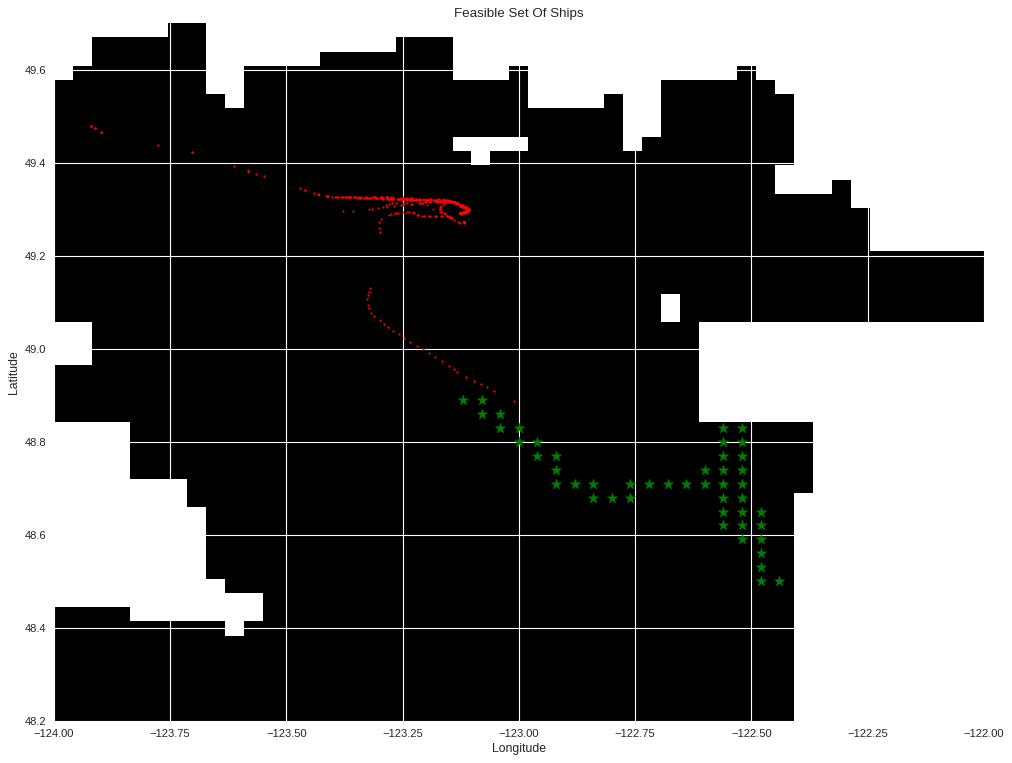

In [88]:
fig = plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Feasible Set Of Ships")
H[H >0] = 1
plt.imshow(H, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.binary)
(X,Y) = list(zip(*set(path)))
plt.scatter(X,Y, marker='*', color='g', s=100)
plt.scatter(x,y, marker='.', color='r', s=10)

In [54]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )